In [1]:
print(f"ipython: {str(get_ipython())}")
from IPython.display import clear_output
import numpy as np
import torch
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    !wandb login
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root_path = '/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/'
else:
    print("Running in personal pc")
    root_path = 'Complementary_Files/zamuro_audios.csv'

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

ipython: <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f5b45eba1a0>
Running on MIRP


In [2]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt

from six.moves import xrange
import datetime
import gc

from scipy import signal

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [3]:
filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.98), len(dataset) - round(len(dataset)*0.98)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "AE-Zamuro",
    "audio_length": dataset.audio_length,
    "batch_size" : 14,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Zamuro",
    "architecture": "AE",
    "win_length" : dataset.win_length,
    "step_size": 3,
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = AE(num_hiddens=config["num_hiddens"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = config["step_size"], gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


0.0001
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1 of 4556 	 loss: 0.0206
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 2 of 4556 	 loss: 0.0224
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 3 of 4556 	 loss: 0.0283
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 4 of 4556 	 loss: 0.249
error
Trying to create tensor with negative dimension -154028: [1, -154028]
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 6 of 4556 	 loss: 0.0037
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 7 of 4556 	 loss: 0.0202
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.S

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 59 of 4556 	 loss: 0.0056
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 60 of 4556 	 loss: 0.0061
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 61 of 4556 	 loss: 0.0077
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 62 of 4556 	 loss: 0.0084
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 63 of 4556 	 loss: 0.0261
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 64 of 4556 	 loss: 0.0184
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 65 of 4556 	 loss: 0.0564

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 117 of 4556 	 loss: 0.0104
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 118 of 4556 	 loss: 0.042
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 119 of 4556 	 loss: 0.0124
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 120 of 4556 	 loss: 0.0187
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 121 of 4556 	 loss: 0.0124
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 122 of 4556 	 loss: 0.0175
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 123 of 4556 	 loss: 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 174 of 4556 	 loss: 0.0061
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 175 of 4556 	 loss: 0.0079
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 176 of 4556 	 loss: 0.012
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 177 of 4556 	 loss: 0.0073
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 178 of 4556 	 loss: 0.0217
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 179 of 4556 	 loss: 0.0079
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 180 of 4556 	 loss: 

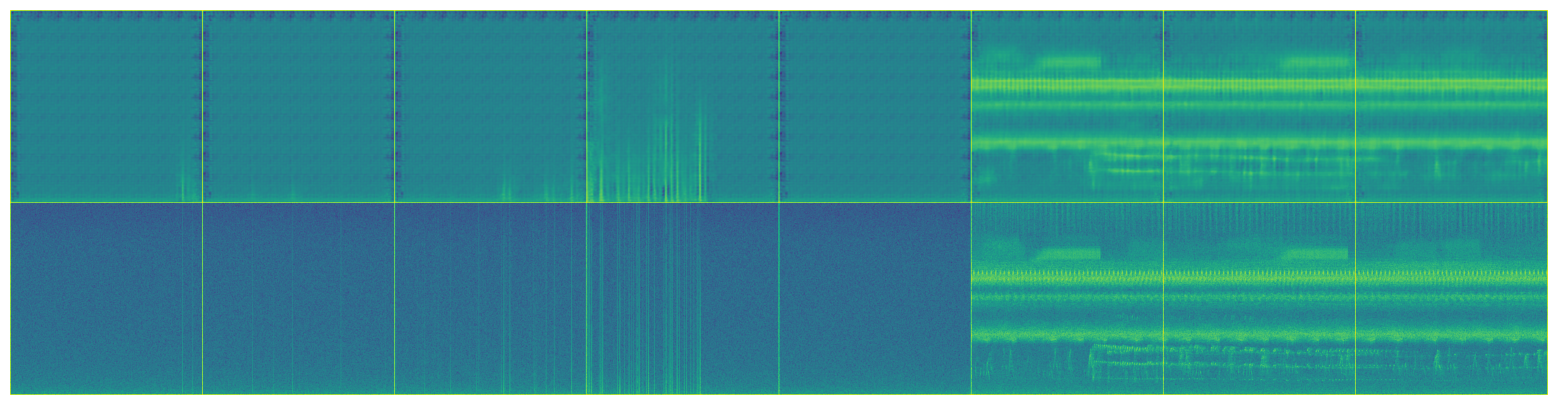

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 201 of 4556 	 loss: 0.0059
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 202 of 4556 	 loss: 0.0042
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 203 of 4556 	 loss: 0.0133
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 204 of 4556 	 loss: 0.0035
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 205 of 4556 	 loss: 0.0216
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 206 of 4556 	 loss: 0.0408
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 207 of 4556 	 loss:

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 258 of 4556 	 loss: 0.0399
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 259 of 4556 	 loss: 0.0354
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 260 of 4556 	 loss: 0.0315
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 261 of 4556 	 loss: 0.0315
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 262 of 4556 	 loss: 0.0027
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 263 of 4556 	 loss: 0.0195
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 264 of 4556 	 loss:

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 316 of 4556 	 loss: 0.0116
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 317 of 4556 	 loss: 0.0235
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 318 of 4556 	 loss: 0.0094
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 319 of 4556 	 loss: 0.0342
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 320 of 4556 	 loss: 0.0036
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 321 of 4556 	 loss: 0.0159
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 322 of 4556 	 loss:

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 373 of 4556 	 loss: 0.0414
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 374 of 4556 	 loss: 0.0174
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 375 of 4556 	 loss: 0.0098
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 376 of 4556 	 loss: 0.009
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 377 of 4556 	 loss: 0.0071
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 378 of 4556 	 loss: 0.0562
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 379 of 4556 	 loss: 

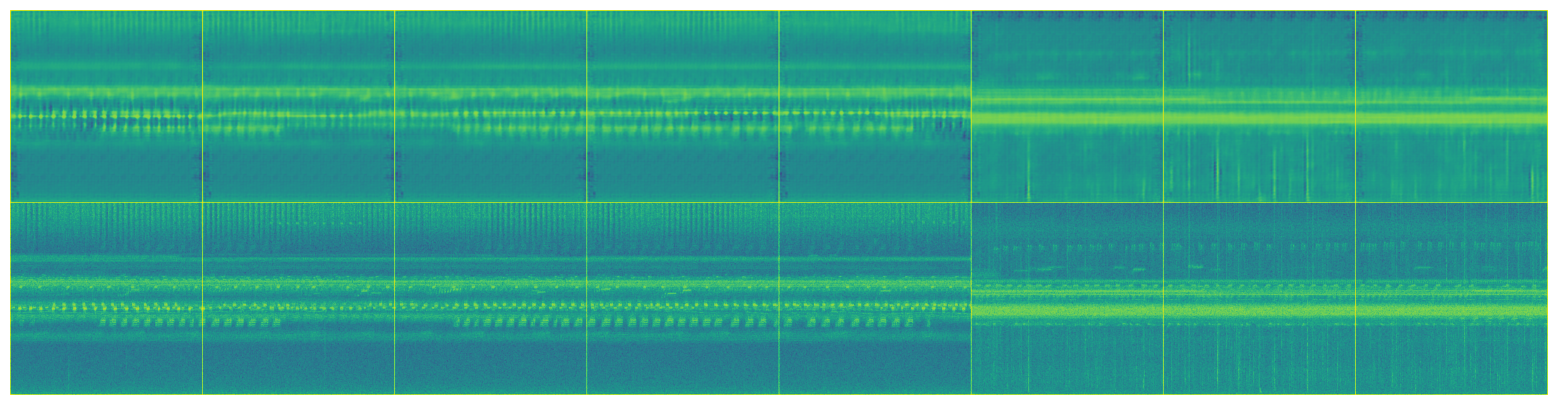

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 401 of 4556 	 loss: 0.0088
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 402 of 4556 	 loss: 0.0137
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 403 of 4556 	 loss: 0.0029
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 404 of 4556 	 loss: 0.0185
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 405 of 4556 	 loss: 0.022
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 406 of 4556 	 loss: 0.0071
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 407 of 4556 	 loss: 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 458 of 4556 	 loss: 0.051
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 459 of 4556 	 loss: 0.0088
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 460 of 4556 	 loss: 0.0069
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 461 of 4556 	 loss: 0.045
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 462 of 4556 	 loss: 0.0287
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 463 of 4556 	 loss: 0.0059
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 464 of 4556 	 loss: 0

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 515 of 4556 	 loss: 0.016
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 516 of 4556 	 loss: 0.0243
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 517 of 4556 	 loss: 0.0378
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 518 of 4556 	 loss: 0.0446
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 519 of 4556 	 loss: 0.0083
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 520 of 4556 	 loss: 0.0169
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 521 of 4556 	 loss: 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 572 of 4556 	 loss: 0.0041
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 573 of 4556 	 loss: 0.0079
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 574 of 4556 	 loss: 0.009
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 575 of 4556 	 loss: 0.0032
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 576 of 4556 	 loss: 0.0106
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 577 of 4556 	 loss: 0.0143
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 578 of 4556 	 loss: 

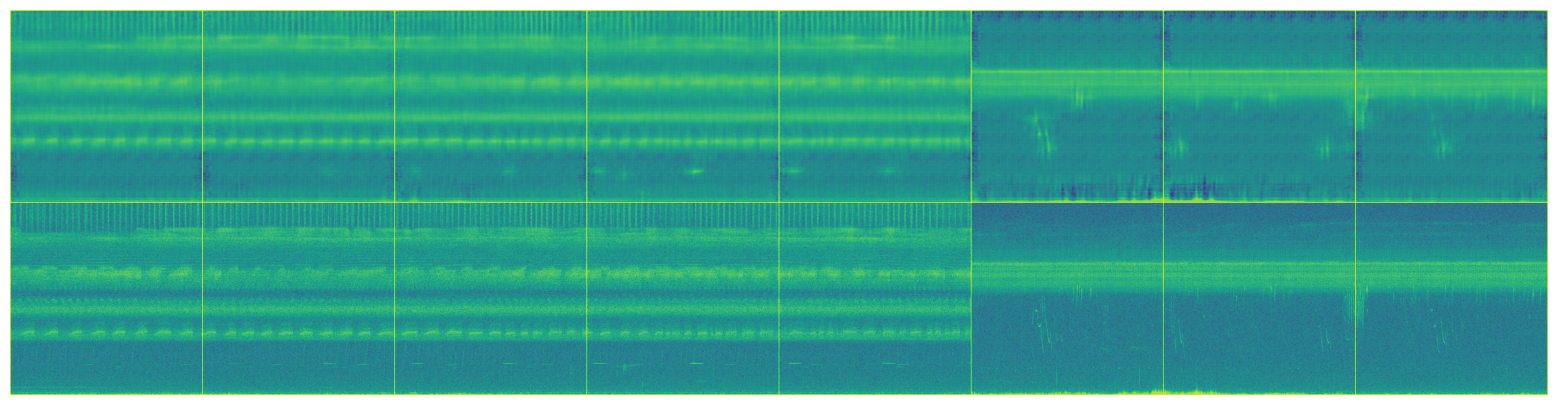

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 601 of 4556 	 loss: 0.0156
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 602 of 4556 	 loss: 0.0343
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 603 of 4556 	 loss: 0.0118
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 604 of 4556 	 loss: 0.0087
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 605 of 4556 	 loss: 0.011
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 606 of 4556 	 loss: 0.0301
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 607 of 4556 	 loss: 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 658 of 4556 	 loss: 0.0099
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 659 of 4556 	 loss: 0.0402
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 660 of 4556 	 loss: 0.0106
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 661 of 4556 	 loss: 0.0101
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 662 of 4556 	 loss: 0.0177
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 663 of 4556 	 loss: 0.0903
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 664 of 4556 	 loss:

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 715 of 4556 	 loss: 0.0136
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 716 of 4556 	 loss: 0.0105
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 717 of 4556 	 loss: 0.0452
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 718 of 4556 	 loss: 0.0157
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 719 of 4556 	 loss: 0.0068
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 720 of 4556 	 loss: 0.0124
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 721 of 4556 	 loss:

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 773 of 4556 	 loss: 0.0424
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 774 of 4556 	 loss: 0.0502
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 775 of 4556 	 loss: 0.0249
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 776 of 4556 	 loss: 0.02
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 777 of 4556 	 loss: 0.0083
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 778 of 4556 	 loss: 0.0059
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 779 of 4556 	 loss: 0

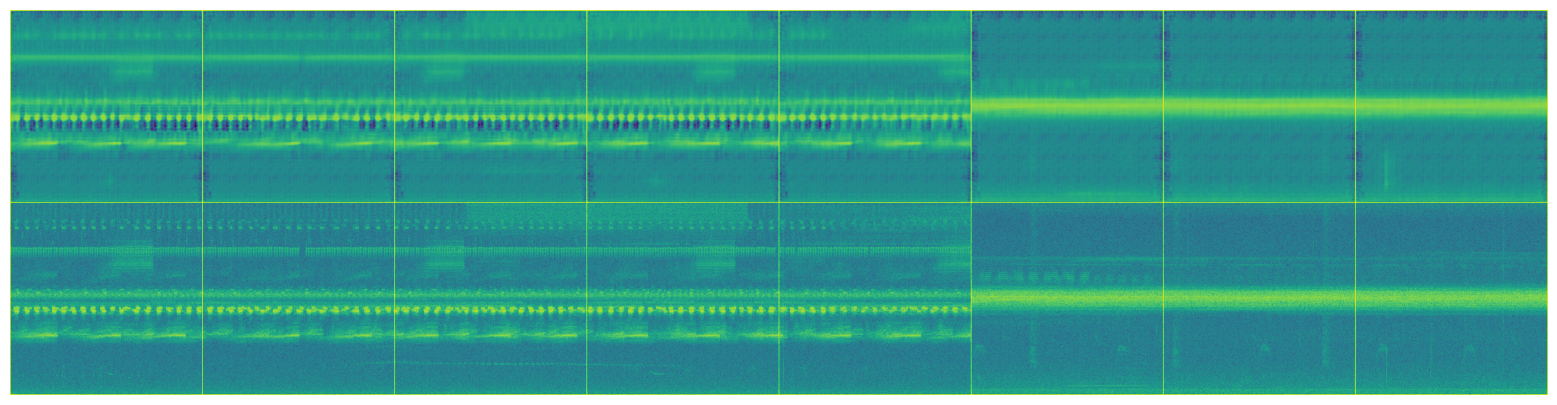

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 801 of 4556 	 loss: 0.0642
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 802 of 4556 	 loss: 0.0098
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 803 of 4556 	 loss: 0.0052
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 804 of 4556 	 loss: 0.0119
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 805 of 4556 	 loss: 0.2429
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 806 of 4556 	 loss: 0.0101
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 807 of 4556 	 loss:

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 858 of 4556 	 loss: 0.2488
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 859 of 4556 	 loss: 0.0124
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 860 of 4556 	 loss: 0.0192
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 861 of 4556 	 loss: 0.0697
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 862 of 4556 	 loss: 0.014
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 863 of 4556 	 loss: 0.0172
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 864 of 4556 	 loss: 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 915 of 4556 	 loss: 0.0168
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 916 of 4556 	 loss: 0.0067
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 917 of 4556 	 loss: 0.01
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 918 of 4556 	 loss: 0.0087
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 919 of 4556 	 loss: 0.0286
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 920 of 4556 	 loss: 0.0585
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 921 of 4556 	 loss: 0

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 972 of 4556 	 loss: 0.0371
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 973 of 4556 	 loss: 0.0044
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 974 of 4556 	 loss: 0.0136
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 975 of 4556 	 loss: 0.0179
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 976 of 4556 	 loss: 0.0108
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 977 of 4556 	 loss: 0.0121
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 978 of 4556 	 loss:

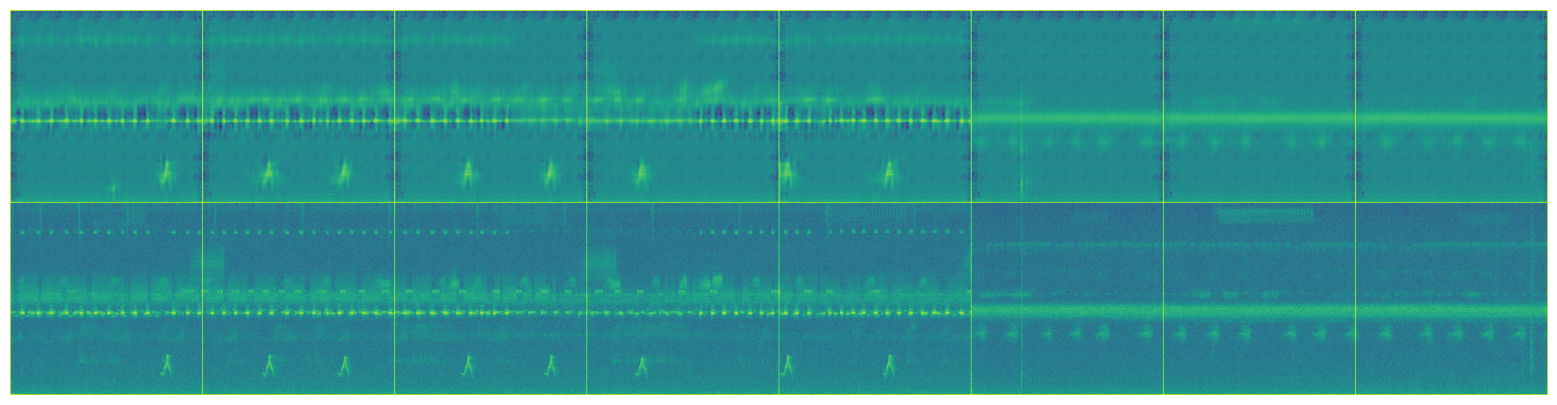

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1001 of 4556 	 loss: 0.0053
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1002 of 4556 	 loss: 0.0133
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1003 of 4556 	 loss: 0.002
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1004 of 4556 	 loss: 0.0418
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1005 of 4556 	 loss: 0.0225
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1006 of 4556 	 loss: 0.0235
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1007 of 4556 	

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1058 of 4556 	 loss: 0.0076
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1059 of 4556 	 loss: 0.0146
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1060 of 4556 	 loss: 0.0188
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1061 of 4556 	 loss: 0.0091
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1062 of 4556 	 loss: 0.0256
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1063 of 4556 	 loss: 0.0088
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1064 of 4556 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1115 of 4556 	 loss: 0.0189
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1116 of 4556 	 loss: 0.0119
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1117 of 4556 	 loss: 0.0158
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1118 of 4556 	 loss: 0.0033
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1119 of 4556 	 loss: 0.0045
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1120 of 4556 	 loss: 0.0139
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1121 of 4556 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1172 of 4556 	 loss: 0.0091
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1173 of 4556 	 loss: 0.0298
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1174 of 4556 	 loss: 0.0058
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1175 of 4556 	 loss: 0.0135
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1176 of 4556 	 loss: 0.0095
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1177 of 4556 	 loss: 0.0212
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1178 of 4556 

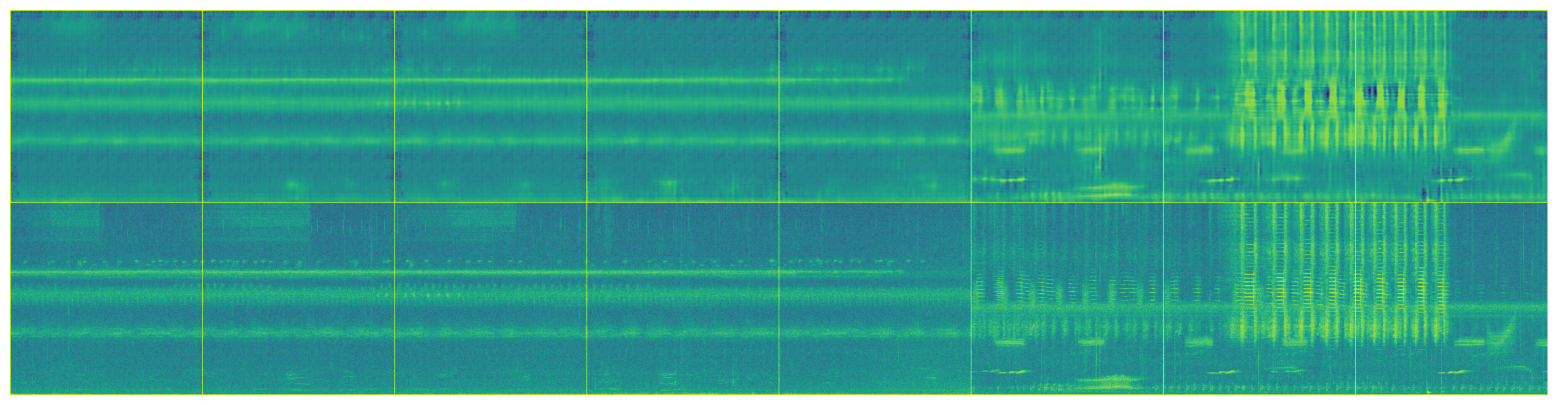

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1201 of 4556 	 loss: 0.0324
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1202 of 4556 	 loss: 0.0151
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1203 of 4556 	 loss: 0.0288
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1204 of 4556 	 loss: 0.0432
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1205 of 4556 	 loss: 0.0277
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1206 of 4556 	 loss: 0.069
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1207 of 4556 	

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1258 of 4556 	 loss: 0.0194
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1259 of 4556 	 loss: 0.0043
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1260 of 4556 	 loss: 0.0107
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1261 of 4556 	 loss: 0.0189
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1262 of 4556 	 loss: 0.0429
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1263 of 4556 	 loss: 0.0071
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1264 of 4556 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1315 of 4556 	 loss: 0.0137
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1316 of 4556 	 loss: 0.0068
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1317 of 4556 	 loss: 0.0396
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1318 of 4556 	 loss: 0.0135
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1319 of 4556 	 loss: 0.0129
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1320 of 4556 	 loss: 0.0627
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1321 of 4556 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1372 of 4556 	 loss: 0.0415
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1373 of 4556 	 loss: 0.0059
error
Trying to create tensor with negative dimension -43014: [1, -43014]
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1375 of 4556 	 loss: 0.0082
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1376 of 4556 	 loss: 0.0401
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1377 of 4556 	 loss: 0.0103
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1378 of 4556 	 loss: 0.0101
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape

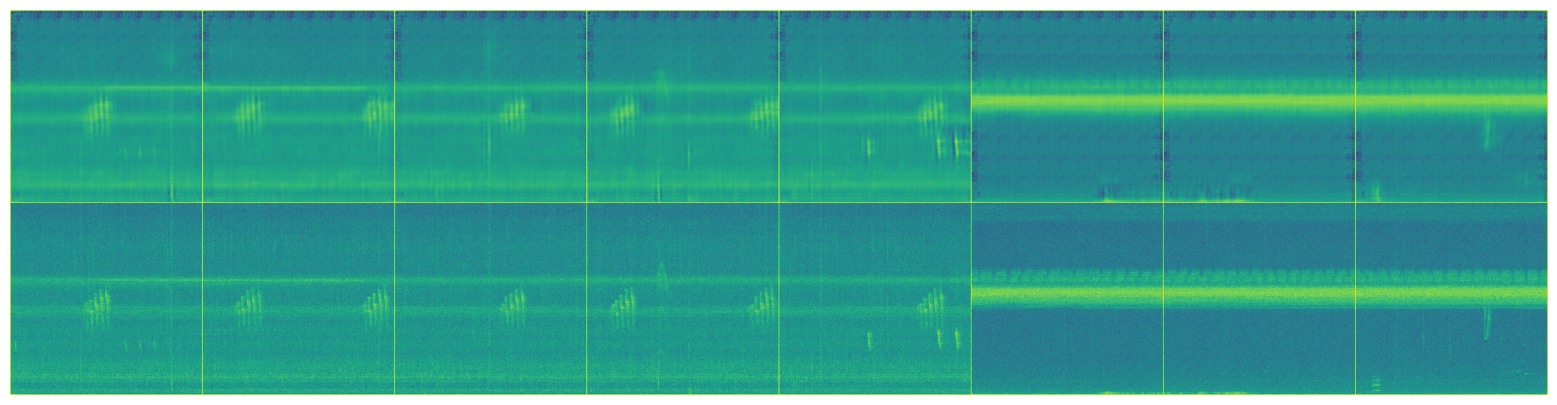

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1401 of 4556 	 loss: 0.0052
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1402 of 4556 	 loss: 0.0191
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1403 of 4556 	 loss: 0.0278
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1404 of 4556 	 loss: 0.0063
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1405 of 4556 	 loss: 0.0206
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1406 of 4556 	 loss: 0.0045
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1407 of 4556 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1458 of 4556 	 loss: 0.1048
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1459 of 4556 	 loss: 0.0401
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1460 of 4556 	 loss: 0.012
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1461 of 4556 	 loss: 0.1942
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1462 of 4556 	 loss: 0.0147
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1463 of 4556 	 loss: 0.015
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1464 of 4556 	 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1515 of 4556 	 loss: 0.0369
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1516 of 4556 	 loss: 0.0043
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1517 of 4556 	 loss: 0.0078
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1518 of 4556 	 loss: 0.0226
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1519 of 4556 	 loss: 0.0089
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1520 of 4556 	 loss: 0.0048
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1521 of 4556 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1572 of 4556 	 loss: 0.0874
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1573 of 4556 	 loss: 0.0048
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1574 of 4556 	 loss: 0.0142
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1575 of 4556 	 loss: 0.0209
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1576 of 4556 	 loss: 0.006
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1577 of 4556 	 loss: 0.0229
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1578 of 4556 	

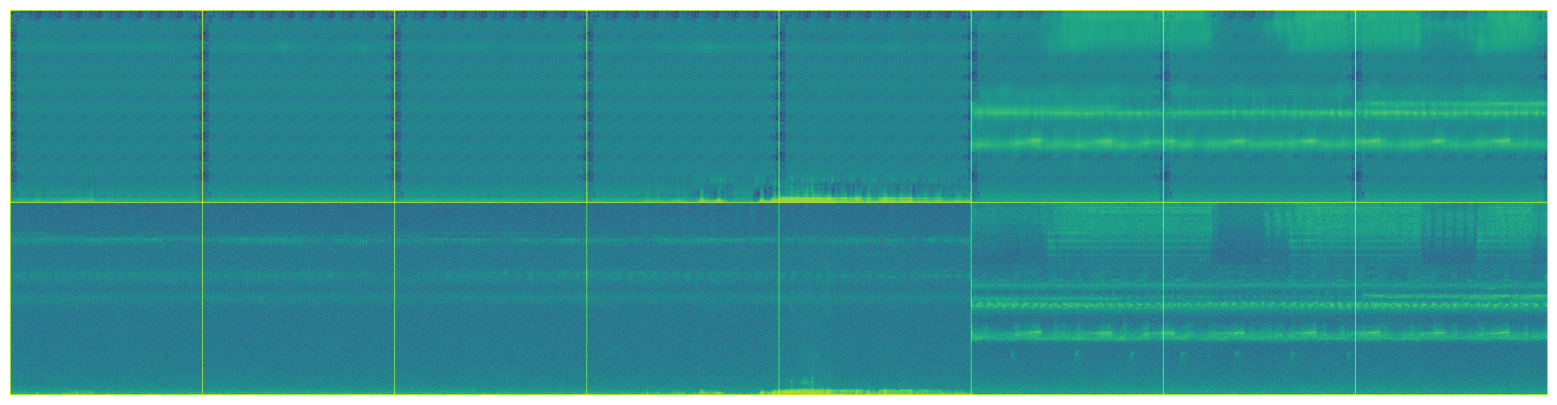

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1601 of 4556 	 loss: 0.0065
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1602 of 4556 	 loss: 0.038
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1603 of 4556 	 loss: 0.0964
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1604 of 4556 	 loss: 0.0174
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1605 of 4556 	 loss: 0.0586
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1606 of 4556 	 loss: 0.0124
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1607 of 4556 	

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1658 of 4556 	 loss: 0.0386
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1659 of 4556 	 loss: 0.0077
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1660 of 4556 	 loss: 0.0029
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1661 of 4556 	 loss: 0.0826
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1662 of 4556 	 loss: 0.0291
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1663 of 4556 	 loss: 0.0151
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1664 of 4556 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1715 of 4556 	 loss: 0.091
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1716 of 4556 	 loss: 0.1105
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1717 of 4556 	 loss: 0.0301
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1718 of 4556 	 loss: 0.0071
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 6 of 10 	 iteration: 1719 of 4556 	 loss: 0.0125


In [ ]:
Training = TrainModel(model)
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
torch.save(config,f'temporal/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
torch.save(dataset_test, f"temporal/datasets/dataset_test_ae_zamuro_{time.day}_70%.pth")
torch.save(dataset_train, f"temporal/datasets/dataset_train_ae_zamuro_{time.day}_70%.pth")

In [ ]:
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas')
model.load_state_dict(torch.load(f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth', map_location=torch.device('cpu')))

In [ ]:
# root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


# dataset = SoundscapeData(root_path, audio_length=12, ext="WAV", win_length=1028)
# dataset_train, dataset_test = random_split(dataset,
#                                            [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
#                                            generator=torch.Generator().manual_seed(1024))
# Dataset_train = DataLoader(dataset_train, batch_size=54, shuffle=True)
# Dataset = DataLoader(dataset_test, batch_size=54, shuffle=True)

training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))


In [ ]:
originals, reconstructions, encodings, label, loss= testing.run()

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin[0:4],2)
testing.plot_psd(wav_origin[10:14],2)
#testing.plot_psd(wav_origin[18:22],2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons[0:4],2)
testing.plot_psd(wav_recons[10:14],2)
#testing.plot_psd(wav_recons[18:22],2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin,2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons,2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)


In [ ]:
plt.plot(wav_origin[12,0])
plt.plot(wav_recons[12,0], color='red', alpha = 0.4)

In [ ]:
# encodings_size = [64,9,9]
# plt.figure(figsize=(18, 18))
# model.to("cpu")
# for i, spec in enumerate(kmeans.cluster_centers_):
#     encodings = spec.reshape(encodings_size)
#     encodings = torch.tensor(encodings).float()
#     decodings = model.decoder(encodings).detach().numpy()
#     plt.subplot(9, 9, i + 1)
#     plt.imshow(decodings[0,:,:], cmap="inferno", interpolation="nearest",vmin=0, vmax=0.02)
#     plt.xticks(())
#     plt.yticks(())
